## 랜덤 포레스트 분류

### 데이터 전처리
- 학습 데이터는 전체 데이터 사용
- Date Feature -> Month(1~12)로 변경
- Mode가 2인 데이터 행을 그냥 삭제(대체 안 함)
- 라벨을 topN 형식으로 10개로 카테고리화

In [78]:
import pandas as pd

# Month Feature를 추가하고 데이터를 섞어서 전처리하는 함수
def df_preprocessing(X, y):
    df_data = X
    df_label = y
    # date Feature를 '월'로 변경(1월 ~ 12월)
    df_data['month'] = df_data.index.str.slice(5, 7).astype(int)
    df_data = df_data.drop(['date'], axis=1)
    # data와 label을 합침
    df = pd.concat([df_data, df_label], axis=1)
    # 이상치로 예상되는 데이터 제거
    df = df[df['mode'] != 2]
    # 만약 라벨이 카테고리화되어 있으면(라벨의 컬럼명이 'top')
    try:
        # 다시 입력값(데이터)와 결과값(라벨)을 분리하여 리턴
        return df.drop(['top'], axis=1), df[['top']]
    # 만약 라벨이 카테고리화되어 있지 않으면(라벨의 컬럼명이 '0')
    except KeyError:
        # 다시 입력값(데이터)와 결과값(라벨)을 분리후 라벨을 카테고리화하여 리턴
        return df.drop(['0'], axis=1), ((df[['0']] - 1) // 10) * 10 + 10

In [79]:
import pandas as pd

# 데이터 받아오기
data = pd.read_csv('../data/dataframes/dataframe_final.csv', index_col=0)
label = pd.read_csv('../data/dataframes/label_categorized_final.csv', index_col=0)

In [80]:
data, label = df_preprocessing(data, label)

### 데이터 스케일링 및 차원축소

- 데이터 표준화
- 데이터 시퀀스화
- 데이터 평탄화

In [81]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
data_std = std.fit_transform(data)
data_std = pd.DataFrame(data_std, columns=data.columns, index=data.index)

In [82]:
data_std

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,month
1963-01-01,-1.573055,1.953269,0.601730,0.649464,-0.293193,-2.173133,1.371827,1.125460,0.675641,0.833884,-1.605021
1963-01-01,-1.009844,-1.357401,-0.094140,0.649464,-0.818130,0.165576,-0.837757,0.639357,-0.257449,-1.106228,-1.605021
1963-01-01,1.333392,1.867278,0.712230,0.649464,-0.605998,-0.506329,-0.376161,-0.880223,1.478532,2.030574,-1.605021
1963-01-01,-0.189364,0.018462,1.080096,0.649464,-0.940376,0.785643,2.711669,2.150768,0.137487,0.718868,-1.605021
1963-01-01,1.465503,1.577057,0.736707,0.649464,0.458259,-0.029815,2.721387,-1.153911,0.923018,0.210706,-1.605021
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.370147,0.915998,-0.938975,0.649464,-0.872062,-0.839291,-0.837757,0.051133,0.515063,0.065890,1.585756
2022-12-26,0.040093,0.846129,0.202391,-1.539731,-0.958353,-1.872072,1.411913,0.782329,0.844899,-0.890834,1.585756
2022-12-26,0.227830,0.518287,-0.468301,0.649464,1.256451,0.368942,-0.746652,0.104236,-0.023091,-0.691124,1.585756
2022-12-26,-0.154597,-0.561980,0.964001,0.649464,1.015555,1.882225,-0.740579,-0.034650,-0.062151,-1.085839,1.585756


In [83]:
import numpy as np
from datetime import datetime

def create_sequences(s_year, dataframe, label):
    Xs, ys = [], []
    curday = datetime(s_year, 1, 1)
    dayformat = curday.strftime('%Y-%m-%d')
    now_idx = ''
    for idx in dataframe.index:
        if now_idx == idx:
            continue
        X = dataframe.loc[dayformat].values
        y = label.loc[dayformat].values
        
        # s = np.arange(X.shape[0])
        # np.random.shuffle(s)
        # X = X[s]
        # y = y[s]
        
        Xs.append(X)
        ys.append(y)
        if idx != dayformat:
            dayformat = idx
        now_idx = idx
        
    return np.array(Xs, dtype=object), np.array(ys, dtype=object)

In [84]:
X, y = create_sequences(1963, data_std, label)
X.shape, y.shape 

((3132,), (3132,))

In [85]:
def sequenceFlatter(X):
    temp = []
    for x in X:
        for i in x:
            temp.append(i)
    temp = np.array(temp)
    return temp

In [86]:
X = sequenceFlatter(X)
y = sequenceFlatter(y)

In [87]:
X.shape

(297677, 11)

In [88]:
y = y.flatten()
y.shape

(297677,)

### 학습셋, 테스트셋 분리

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [90]:
X_train

array([[-1.57305463,  1.95326902,  0.60172965, ...,  0.67564106,
         0.83388417, -1.60502149],
       [-1.0098437 , -1.35740064, -0.09413993, ..., -0.25744873,
        -1.10622784, -1.60502149],
       [ 1.33339187,  1.8672776 ,  0.71222954, ...,  1.47853227,
         2.03057412, -1.60502149],
       ...,
       [-0.48139888,  1.14709946, -1.258585  , ..., -0.72182365,
        -0.7214468 , -0.44473874],
       [ 0.14439103,  1.2008441 ,  0.10238203, ...,  1.97762681,
         0.00733685, -0.44473874],
       [-1.8581367 , -0.01378471, -0.84246199, ..., -1.01694042,
         0.2389374 , -0.44473874]])

In [91]:
y_train

array([ 10,  10,  10, ..., 100, 100, 100], dtype=int64)

### PCA 데이터 생성

[2.15041308 1.40539586 1.16328433 1.02149741 0.99949293 0.96095022
 0.9228555  0.89067453 0.66906275 0.56692242 0.3035385 ]
[0.19453556 0.12713812 0.10523567 0.09240902 0.0904184  0.08693166
 0.08348545 0.08057422 0.06052628 0.05128622 0.02745939]


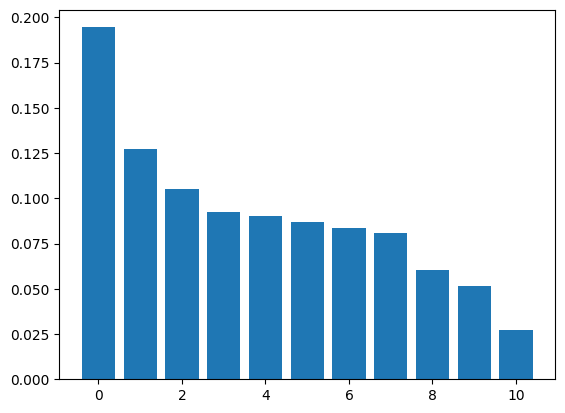

In [92]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

x_length = len(X_train[0])
x = np.arange(x_length)

import matplotlib.pyplot as plt 

plt.bar(x, pca.explained_variance_ratio_)
plt.show()

In [93]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### LDA 데이터 생성

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=9)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

### 모델링
- 표준화 데이터, PCA 데이터, LDA 데이터로 나눠서 모델을 각각 학습

In [95]:
from sklearn.ensemble import RandomForestClassifier

def modelingAndVisualizing(X_train, X_test, title):
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    
    train_score = rfc.score(X_train, y_train)
    test_score = rfc.score(X_test, y_test)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print('검증 정확도 : ', round(test_score, 3))
    
    plt.plot(range(100), y_test[:100], label='True')
    plt.plot(range(100), y_pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return rfc

Standardized
학습 정확도 :  0.621
검증 정확도 :  0.103


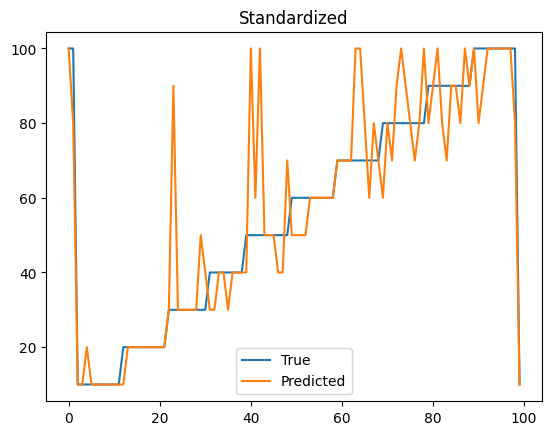

Model saved to models/rf-Standardized.pkl
Standardized_PCA
학습 정확도 :  0.621
검증 정확도 :  0.104


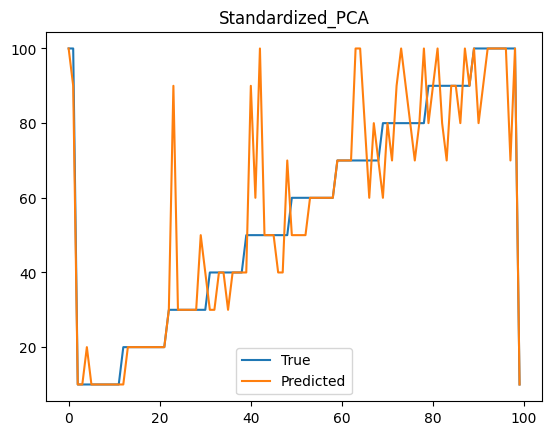

Model saved to models/rf-Standardized_PCA.pkl
Standardized_LDA10
학습 정확도 :  0.621
검증 정확도 :  0.103


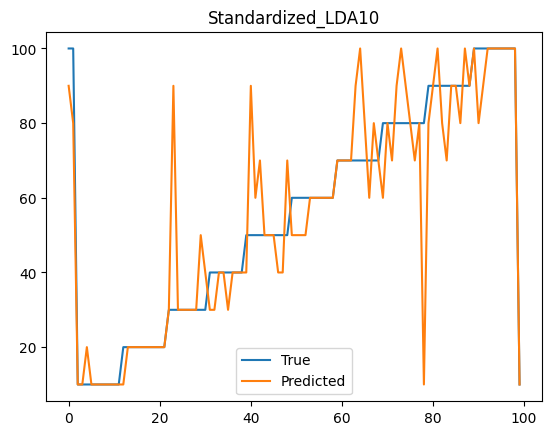

Model saved to models/rf-Standardized_LDA10.pkl


In [96]:
modelingList = [
    (X_train, X_test, 'Standardized'),
    (X_train_pca, X_test_pca, 'Standardized_PCA'),
    (X_train_lda, X_test_lda, 'Standardized_LDA10')
]

modelList = []

import pickle
import os

for model in modelingList:
    rfc = modelingAndVisualizing(*model)
    # save model to file
    if not os.path.exists('models'):
        os.makedirs('models')
    filePath = 'models/rf-' + model[2] + '.pkl'
    pickle.dump(rfc, open(filePath, 'wb'))
    print('Model saved to', filePath)
    modelList.append(rfc)

- 학습 자체는 잘 됨

### 2023년 데이터로 검증

In [97]:
# 2023년도 데이터 받아오기
data2023 = pd.read_csv('../data/dataframes/dataframe_2023to2023.csv', index_col=0)
label2023 = pd.read_csv('../data/dataframes/label_2023to2023.csv', index_col=0)

- 전처리

In [98]:
data2023, label2023 = df_preprocessing(data2023, label2023)

- 표준화

In [99]:
data2023_std = std.fit_transform(data2023)
data2023_std = pd.DataFrame(data2023_std, columns=data2023.columns, index=data2023.index)

In [100]:
data2023_std

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,month
2023-01-01,-1.879995,-0.196243,1.088463,0.735938,-0.662180,0.079599,-0.743352,-1.639746,-0.617234,0.265187,-1.582432
2023-01-01,-0.345532,-1.171075,1.560483,0.735938,-0.188965,1.296127,-0.743352,1.995038,1.562017,0.880499,-1.582432
2023-01-01,0.864883,-1.376773,1.488654,0.735938,-0.769728,1.315234,-0.743352,-1.750902,1.314033,-1.127360,-1.582432
2023-01-01,0.702859,-1.144245,-1.615392,0.735938,-1.178414,0.187876,1.136149,1.650456,1.659707,-1.455835,-1.582432
2023-01-01,0.293034,-1.591415,-1.605131,0.735938,-1.113885,1.232434,-0.743352,-1.528591,1.584561,-0.160442,-1.582432
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,-0.212100,1.368854,-1.343468,0.735938,0.348780,-0.621020,-0.743352,1.539301,1.118652,0.274440,1.560370
2023-12-31,0.502712,1.189986,-0.850925,-1.358810,0.865014,-0.837574,-0.743352,1.550416,1.344092,-1.511352,1.560370
2023-12-31,-1.117529,0.921683,-0.455864,0.735938,-1.149734,-0.060525,-0.535568,-0.228072,-0.113752,0.168033,1.560370
2023-12-31,1.284239,1.780251,-0.558478,-1.358810,-0.525951,0.168768,0.597799,-0.027992,1.652193,-0.877534,1.560370


- 시퀀스화

In [101]:
X2023, y2023 = create_sequences(2023, data2023_std, label2023)
X2023.shape, y2023.shape 

((53,), (53,))

- 평탄화

In [102]:
X2023 = sequenceFlatter(X2023)
y2023 = sequenceFlatter(y2023)

- 표준화, PCA, LDA

In [111]:
X2023_std = std.transform(X2023)
X2023_pca = pca.transform(X2023)
X2023_lda = lda.transform(X2023)

c:\Users\user\Desktop\project2\BillboardAnalitics\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 모델 입력 및 시각화

In [112]:
data2023 = [
    (X2023_std, 'Standardized'),
    (X2023_pca, 'Standardized_PCA'),
    (X2023_lda, 'Standardized_LDA')
]

Standardized
2023년 데이터 예측 정확도 :  0.1


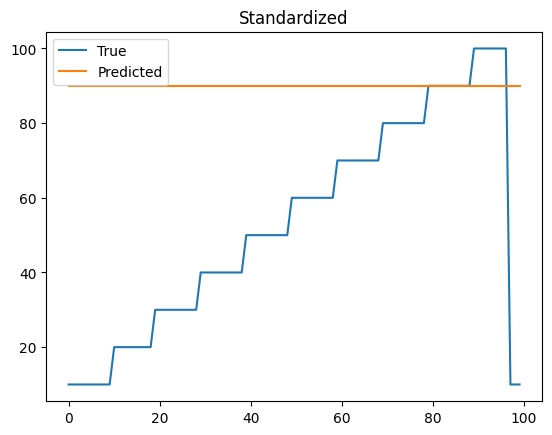

Standardized_PCA
2023년 데이터 예측 정확도 :  0.096


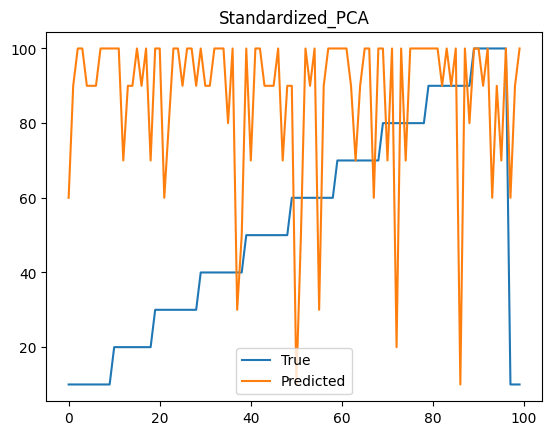

Standardized_LDA
2023년 데이터 예측 정확도 :  0.099


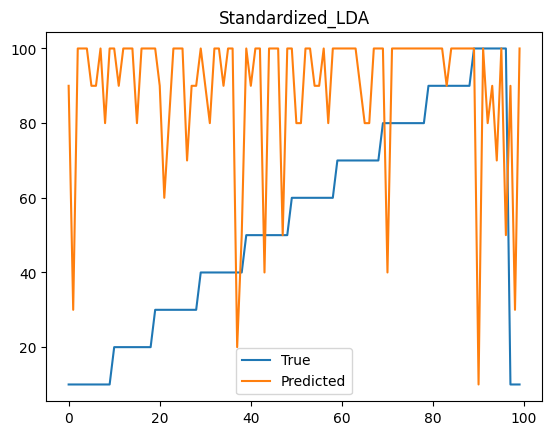

In [113]:
for data, model in zip(data2023, modelList):
    y2023_pred = model.predict(data[0])
    
    score = model.score(data[0], y2023.ravel())


    print(data[1])
    print('2023년 데이터 예측 정확도 : ', round(score, 3))
    
    plt.plot(range(100), y2023[:100], label='True')
    plt.plot(range(100), y2023_pred[:100], label='Predicted')
    plt.title(data[1])
    plt.legend()
    plt.show()